In [1]:
import pandas as pd
import numpy as np
import pprint as pp 
import scipy.stats as st 

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

#### Let's first break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%) 

In [2]:
# Set seed
np.random.seed(1234)

# read in the data file 
turnout = pd.read_csv('turnout.csv')

In [3]:
# train-test split 
train = turnout.sample(frac = .8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

In [4]:
# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,id,age,educate,income,vote,white
0,1749,78,16.0,1.3131,1,1
1,935,72,3.0,0.6765,1,0
2,1034,64,10.0,1.3131,1,1
3,244,80,8.0,1.1839,1,1
4,929,19,14.0,2.9072,1,1


#### The next step is to build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). We are going to first calculate the probability for people who voted and people who didn't vote. 

In [6]:
# Calculate Class Probability 
N = train.shape[0]

# Subset the data by class
vote1 = train.query('vote == 1')
vote0 = train.query('vote == 0')

# Calculate the probability for each class
pr_vote1 = vote1.shape[0]/N
pr_vote0 = vote0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vote1}
Pr(vote = 0): {pr_vote0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



#### Based on the results, the probability of people who voted in the training dataset is 74.25%. The probability of people who didn't vote in the training dataser is 25.75%. 

#### Then, we are going to calculate the conditional probabilities for binary predictors given the binary outcome variable 𝑃𝑟( 𝑑𝑎𝑡𝑎 | 𝑐𝑙𝑎𝑠𝑠 ) 

In [7]:
# for people who voted 
white1_vote1 = vote1.query('white == 1').shape[0]/vote1.shape[0]
white0_vote1 = vote1.query('white == 0').shape[0]/vote1.shape[0]

# for people who didn't vote 
white1_vote0 = vote0.query('white == 1').shape[0]/vote0.shape[0]
white0_vote0 = vote0.query('white == 0').shape[0]/vote0.shape[0]

#print the conditional probabilities 
print(
f"""
Pr(white = 1 | vote = 1): {white1_vote1}
Pr(white = 0 | vote = 1): {white0_vote1}
Pr(white = 1 | vote = 0): {white1_vote0}
Pr(white = 0 | vote = 0): {white0_vote0}
"""
)



Pr(white = 1 | vote = 1): 0.8686868686868687
Pr(white = 0 | vote = 1): 0.13131313131313133
Pr(white = 1 | vote = 0): 0.7985436893203883
Pr(white = 0 | vote = 0): 0.20145631067961164



#### Based on the conditional probability, for people who voted, 86.87% are white, and 13.13% are not white. For people who didn't vote, 79.85% are white, and 20.15% are not. 

#### Then, let's move on to build the classifier with the continuous predictors. We are going to use the probability density function for Gaussian (normal) distribution to convert continuous values into probabilities to make predictions. The first step is to collect the mean and standard deviation of each conditional distribution. Let's also include the race indicator since we want to put all the predicators in one graph later. 

In [11]:
# collect the mean and standard deviation of each conditional distribution
dist_locs = \
{
    ('age',1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
    ('age',0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
    ('educate',1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
    ('educate',0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
    ('income',1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
    ('income',0):{'mean':vote0.income.mean(),'sd':vote0.income.std()},
    ('white',1):{'mean':vote1.white.mean(),'sd':vote1.white.std()},
    ('white',0):{'mean':vote0.white.mean(),'sd':vote0.white.std()}
}

# print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853716},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.304381091983527},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.295714127444309},
 ('income', 0): {'mean': 2.7381618932038836, 'sd': 2.2429913729337625},
 ('income', 1): {'mean': 4.229461952861947, 'sd': 2.8482089910676964},
 ('white', 0): {'mean': 0.7985436893203883, 'sd': 0.4015757472901712},
 ('white', 1): {'mean': 0.8686868686868687, 'sd': 0.3378847322122307}}


#### Based on the mean and standard deviation of each conditional distribution, we can observe that the people who are older, more educated, and with higher income tend to vote. There is one thing we need to pay attention to that the standard deviation of age for the whole population in the dataset is higher than that of education level and income level, indicating that the age is less normally distributed and the variation is larger. 

#### Next, we are going to use the conditonal probability to make a plot. 

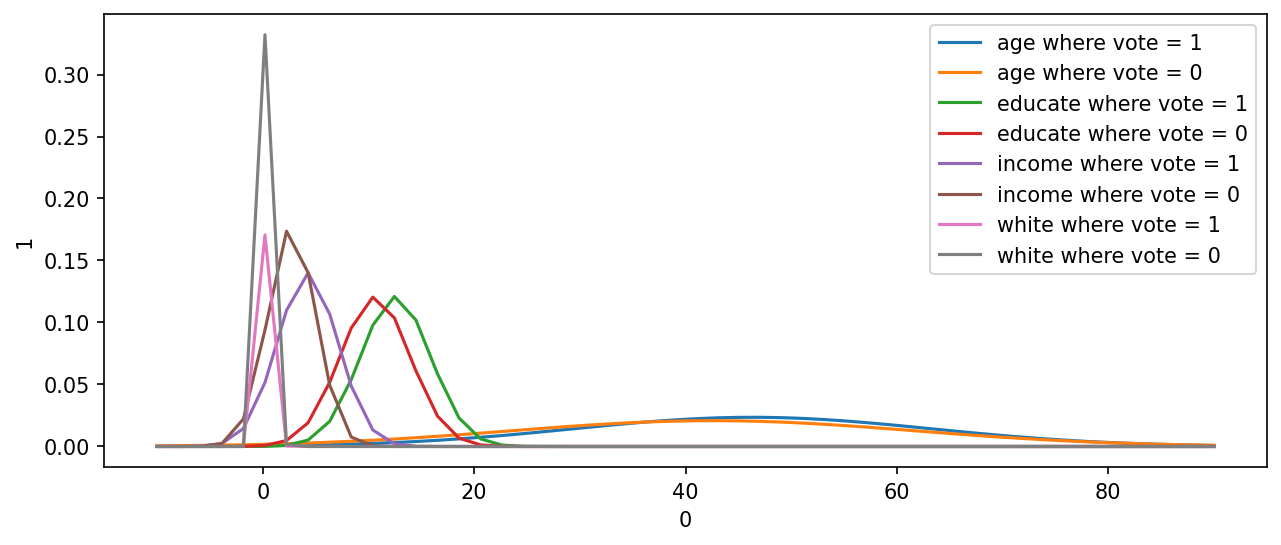

In [17]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,90)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")

#### Now, we visualized all the conditional distributions. Let's create a function to make a prediction of whether people would vote given people's different characteristics 

In [20]:
def predict(data,dist_locs):
    '''
    This is a function that predicts which outcome is more likely 
    for a binary outcome variable given different characteristics
    
    Args:
    It takes in a dataset and a dictionary containing means and standard 
    deviation of conditional distribution for all the predictors in that dataset 
    
    Returns:
    It returns a dataframe that displays the probability of the two possible outcomes 
    for the binary outcome variables and the predicted result. 
    '''
    
    # Create an empty list to store the predictions
    store_preds = []
    
    # Iterate over the dataframe rows as pairs 
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        
        # for each data point given different characteristics, use the probability density function
        # to convert each continuous value into probability and multiply them to get the final probability 
        for j in range(1,len(row)):
            if row.index[j] != "vote":
                
                pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                                dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
            
        pr_0 *= pr_vote0
        pr_1 *= pr_vote1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])


#### Let's use the function with our training dataset to see whether the function works

In [21]:
# Run 
preds_train = predict(train,dist_locs)

# look at the head 
preds_train.head(10)

,pr_0,pr_1,pred
0,3.984875e-06,1.935371e-05,1
1,2.224761e-07,2.785280e-08,0
2,4.337782e-05,8.247596e-05,1
3,8.588786e-06,9.733822e-06,1
4,2.797497e-05,7.201115e-05,1
5,2.615106e-06,1.553231e-06,0
6,5.286035e-05,9.446765e-05,1
7,1.546110e-05,6.905513e-05,1
8,3.704909e-05,1.123144e-04,1
9,3.758902e-05,1.640475e-04,1


#### We are also interested in the accuracy of our predictions. Let's examine the predictive accuracy of the training data 

In [22]:
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]
accuracy_train

0.725625

#### Let's also try to examine the predictive accuracy of the test data 

In [26]:
preds_test = predict(test,dist_locs)
accuracyTest = sum(test.vote == preds_test.pred)/test.shape[0]
accuracyTest

0.7125

#### So, 72.56% of the predictions is accuracy based on the predictive accuracy of the training data. The predictive accuracy of the test data is 0.7125, which is quite high in terms of predictive accuracy. So, this classifier can predict whether a person votes with around 72% accuracy. 

#### Let's also make a ROC curve to visualize the predictive accuracy 

In [27]:
# Organize our data real quick so it plugs into the sklearn API easily 
train_vote = train['vote']
train_x = train[['age','educate','income','white']]
test_vote = test['vote']
test_x = test[['age','educate','income','white']]

In [28]:
# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_vote) # Train

# Predict 
vote_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_vote,vote_pred)

0.7125

#### Since we want to generate a ROC curve, we want the model to return probabilities instead of predictions.

In [29]:
# Generate probabilities 
probs =  gnb.predict_proba(test_x)

# Convert the probabilities into a data frame 
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.382004,0.617996
1,0.089185,0.910815
2,0.275975,0.724025
3,0.255162,0.744838
4,0.036055,0.963945
...,...,...
395,0.168330,0.831670
396,0.274707,0.725293
397,0.021379,0.978621
398,0.438499,0.561501


In [30]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_vote, probs[1])

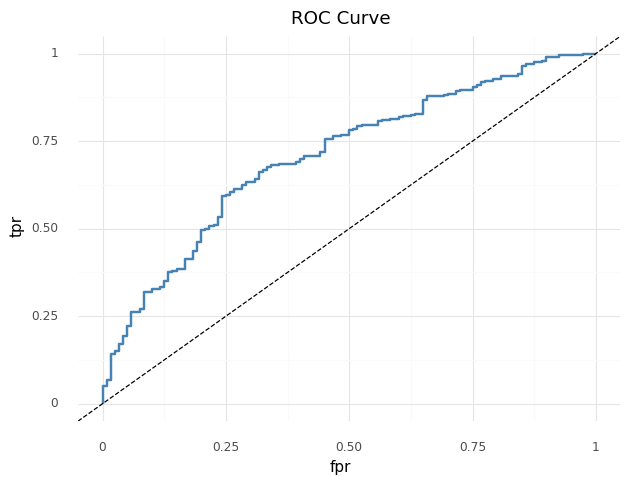

<ggplot: (8769787525268)>

In [31]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

In [32]:
# Calculate the AUC score
m.roc_auc_score(test_vote,vote_pred)

0.575595238095238

#### The ROC curve does not deviate from the dashed line by a lot, so it can not different true positive and false positive very efficiently. The area under the ROC curve, as suggested by the auc score is 57.5%, which means that it is only a little better than chance (50%)

#### Discussion

#### The predictive accuracy of our classifier is around 72%, however, the auc is only about 57%. So, our model is just a little bit better than chance. The predictive accuracy is about 0.72, meaning that the classifier can indeed correctly predict the outcome of an observation 72% of the time. So, this model is not perfect but it is better than flip a coin. So, one should be cautious using this model to predict whether a person would vote. 